# Equivariance and Invariance of Materials' Properties

### Setup

In [1]:
!pip install fairchem-core
!pip install torch_geometric
!pip install py3Dmol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 284.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.3/373.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/

### Install our alignment package: torch_canon
https://github.com/JustinBakerMath/alignment

In [2]:
!pip install spherical_geometry
!git clone https://github.com/JustinBakerMath/alignment.git
%cd alignment
!pip3 install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 41.9 MB/s eta 0:00:00
Cloning into 'alignment'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 421 (delta 199), reused 353 (delta 135), pack-reused 0 (from 0)
Receiving objects: 100% (421/421), 120.81 KiB | 4.65 MiB/s, done.
Resolving deltas: 100% (199/199), done.
/content/alignment
Obtaining file:///content/alignment
  Preparing metadata (setup.py) ... done
  Running setup.py develop for torch_canon


### Import

In [3]:
from torch_canon.pointcloud import CanonEn as Canon

%cd ..
import argparse
import sys
import logging

import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.stats import wasserstein_distance_nd

import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader

#from pointgroup import PointGroup




/content


### Meta Open Materials 2024 (OMat24) Dataset

https://arxiv.org/html/2410.12771v1 /
https://huggingface.co/datasets/fairchem/OMAT24

The best demo: https://ase-notebook.readthedocs.io/en/latest/user_guide/tutorial_intro.html


In [ ]:
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.dgl.ai/wheels/repo.html

In [ ]:
from fairchem.core.datasets import AseDBDataset
from ase.calculators.lj import LennardJones
from ase.spacegroup import crystal
import numpy as np

import spglib


calc = LennardJones()

dataset = AseDBDataset(config=dict(src="val.aselmdb"))

# atoms objects can be retrieved by index
#atoms = dataset.get_atoms(100)
#atoms = dataset.get_atoms(6)
#atoms = dataset.get_atoms(3)
#atoms = dataset.get_atoms(5)
#print(atoms.info("spacegroup"))

## Crystal Structures

In [4]:
from ase.calculators.lj import LennardJones
from ase.spacegroup import crystal
import numpy as np

import spglib


calc = LennardJones()

#dataset = AseDBDataset(config=dict(src="val.aselmdb"))

# atoms objects can be retrieved by index
#atoms = dataset.get_atoms(100)
#atoms = dataset.get_atoms(6)
#atoms = dataset.get_atoms(3)
#atoms = dataset.get_atoms(5)
#print(atoms.info("spacegroup"))


# Create Diamond
a = 3.57
atoms = crystal('C', [(0, 0, 0)], spacegroup=227,
                  cellpar=[a, a, a, 90, 90, 90])


#atoms = dataset.get_atoms(i)

# Extract lattice vectors and atomic positions
lattice = atoms.cell.array  # Get the lattice vectors
positions = atoms.positions   # Get atomic positions
numbers = atoms.numbers       # Get atomic numbers

# Use spglib to find the space group
try:
    # Create a structure for spglib
    structure = (lattice, positions, numbers)
    space_group_info = spglib.get_spacegroup(structure)
    space_group = space_group_info[0]  # Get the space group symbol
    #print(f"Space Group: {space_group_info}")
    if space_group_info != 'P1 (1)':
        print(space_group_info, type(space_group_info))
        print(f"Space Group: {space_group_info}")
except Exception as e:
    print(f"Error determining space group: {e}")




R3m (160) <class 'str'>
Space Group: R3m (160)


### Details of `atoms` object

In [ ]:
help(atoms)

Help on Atoms in module ase.atoms object:

class Atoms(builtins.object)
 |  Atoms(symbols=None, positions=None, numbers=None, tags=None, momenta=None, masses=None, magmoms=None, charges=None, scaled_positions=None, cell=None, pbc=None, celldisp=None, constraint=None, calculator=None, info=None, velocities=None)
 |  
 |  Atoms object.
 |  
 |  The Atoms object can represent an isolated molecule, or a
 |  periodically repeated structure.  It has a unit cell and
 |  there may be periodic boundary conditions along any of the three
 |  unit cell axes.
 |  Information about the atoms (atomic numbers and position) is
 |  stored in ndarrays.  Optionally, there can be information about
 |  tags, momenta, masses, magnetic moments and charges.
 |  
 |  In order to calculate energies, forces and stresses, a calculator
 |  object has to attached to the atoms object.
 |  
 |  Parameters:
 |  
 |  symbols: str (formula) or list of str
 |      Can be a string formula, a list of symbols or a list of
 |

## Alignment


In [5]:
frame = Canon(tol=1e-6)

normalized_positions, frame_R, frame_t = frame.get_frame(atoms.positions, atoms.numbers)

print(atoms.positions.mean(axis = 0)- frame_t.numpy())
print(atoms.positions- normalized_positions@frame_R.numpy()- frame_t.numpy())


atoms_aligned = atoms.copy()
atoms_aligned.positions = normalized_positions


[0. 0. 0.]
[[-1.38859050e-07 -1.38859049e-07 -4.31996414e-08]
 [-3.34601036e-08  1.54952187e-08 -2.09871354e-08]
 [-3.20671327e-08 -2.40026108e-08 -2.80725214e-08]
 [ 1.92408862e-08 -3.77789573e-08  3.46597764e-08]
 [ 1.11813586e-07  5.47937418e-08  6.34595372e-08]
 [-4.62863501e-08 -4.62863496e-08 -1.43998804e-08]
 [ 5.91125968e-08  1.08067918e-07  7.81262544e-09]
 [ 6.05055674e-08  6.85700885e-08  7.27239602e-10]]


## The Asymmetric Unit (ASU)

In [53]:
from ase.visualize import view

atoms_asu = atoms.copy()

list_of_asu_atoms = [5, 1, 0, 6]
# Assign tags to differentiate the atoms
# Let's assign tag=1 to four atoms and tag=2 to the other four
for i in range(len(atoms_asu)):
    if i in list_of_asu_atoms:
        atoms_asu.numbers[i] = 8
    else:
        atoms_asu.numbers[i] = 10

_ = atoms_to_html(atoms_asu, "diamond_asu.html")
# Visualize with color by tag
view(atoms_asu, viewer="x3d")




In [55]:
ASUN = Canon(tol=1e-6, save = True)
_ = ASUN.get_frame(atoms.positions, atoms.numbers)


for i in range(len(atoms_asu)):
    if i in ASUN.simple_asu:
        atoms_asu.numbers[i] = 8
    else:
        atoms_asu.numbers[i] = 10

_ = atoms_to_html(atoms_asu, "diamond_asu_from_our_code.html")

view(atoms_asu, viewer="x3d")



## Visualize Materials

In [ ]:
print(f"atoms.symbols:{atoms.symbols}")
original_positions = atoms.positions
print(f"atoms.positions:{atoms.positions}")
print(f"atoms.numbers:{atoms.numbers}")
print(f"atoms.cell:{atoms.cell}")
print(f"atoms.celldisp:{atoms.get_celldisp()}")
#print(atoms.info["spacegroup"])

atoms.symbols:C8
atoms.positions:[[0.     0.     0.    ]
 [0.     1.785  1.785 ]
 [1.785  1.785  0.    ]
 [1.785  0.     1.785 ]
 [2.6775 0.8925 2.6775]
 [0.8925 0.8925 0.8925]
 [0.8925 2.6775 2.6775]
 [2.6775 2.6775 0.8925]]
atoms.numbers:[6 6 6 6 6 6 6 6]
atoms.cell:Cell([3.57, 3.57, 3.57])
atoms.celldisp:[[0.]
 [0.]
 [0.]]


### 2D

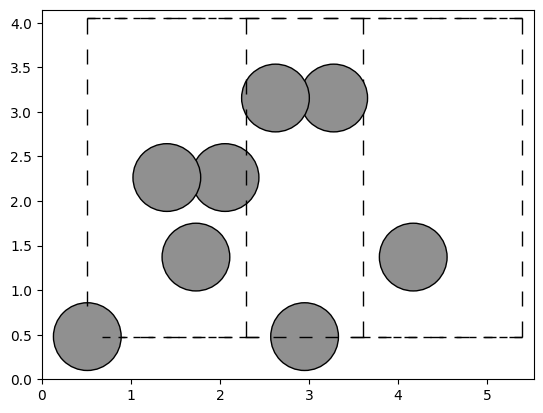

In [ ]:
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt


# Create a 2D plot of the structure
plot_atoms(atoms, rotation='30y', show_unit_cell=2, radii=0.5)

# Show the plot
plt.show()

### HTML

In [ ]:
from IPython.display import HTML

def atoms_to_html(atoms, output_filename='atoms_visualization.html'):
    """Return the HTML representation of the atoms object as a file."""

    # Use NamedTemporaryFile to store the HTML representation temporarily
    from tempfile import NamedTemporaryFile

    with NamedTemporaryFile('r+', suffix='.html') as ntf:
        atoms.write(ntf.name, format='html')
        ntf.seek(0)
        html_content = ntf.read()

    # Write the HTML content to a specified output file
    with open(output_filename, 'w') as output_file:
        output_file.write(html_content)

    return html_content  # You can return it for display in Jupyter as well

from  ase.build import  molecule
tbut = molecule('trans-butane')
tbut_html = atoms_to_html(atoms, "diamond.html")

HTML(tbut_html)

### 3D

In [49]:
from ase.visualize import view

atoms.positions = atoms.positions - atoms.positions.mean(axis = 0)
atoms.wrap()

print(atoms.tag[1])
#atoms_repeated = atoms.repeat((3,3,3))
#view(atoms_repeated, viewer="x3d")

# built-in output
#from ase.io import write
#write('image.png', atoms)

_ = atoms_to_html(atoms, "diamond.html")
view(atoms, viewer="x3d")


AttributeError: 'Atoms' object has no attribute 'tag'

In [ ]:
frame = Canon(tol=1e-6)

normalized_positions, frame_R, frame_t = frame.get_frame(atoms.positions, atoms.numbers)

#print(atoms.positions.mean(axis = 0)- frame_t.numpy())
#print(atoms.positions- normalized_positions@frame_R.numpy()- frame_t.numpy())


atoms_aligned = atoms.copy()
atoms_aligned.positions = normalized_positions
atoms_aligned.cell = (atoms.cell)@(frame_R.numpy().T)
atoms_aligned.wrap()


# output the result as html
_ = atoms_to_html(atoms_aligned, "diamond_aligned.html")
view(atoms_aligned, viewer="x3d")

In [39]:
from ase.build import molecule
from IPython.display import HTML

def atoms_to_html(atoms, output_filename='atoms_visualization.html'):
    """Return the HTML representation of the atoms object as a string."""

    from tempfile import NamedTemporaryFile

    with NamedTemporaryFile('r+', suffix='.html') as ntf:
        atoms.write(ntf.name, format='html')
        ntf.seek(0)
        html_content = ntf.read()

    # Write the HTML content to a specified output file
    with open(output_filename, 'w') as output_file:
        output_file.write(html_content)

    return html_content  # You can return it for display in Jupyter as well


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R
def rotation_matrix_from_axis_angle(axis, angle):
    """Create a rotation matrix from an axis and angle."""
    axis = axis / np.linalg.norm(axis)  # Normalize the axis
    return R.from_rotvec(axis * angle).as_matrix()

def interpolate_rotations(Q_start, Q_end, steps):
    """Interpolate between two rotation matrices Q_start and Q_end."""
    r_start = R.from_matrix(Q_start).as_rotvec()  # Rotation vector for start
    r_end = R.from_matrix(Q_end).as_rotvec()  # Rotation vector for end

    rotations = []
    for i in range(steps + 1):
        t = i / steps
        r_interp = (1 - t) * r_start + t * r_end
        Q_interp = R.from_rotvec(r_interp).as_matrix()  # Interpolated rotation matrix
        rotations.append(Q_interp)
    return rotations


# Your original coordinates and orthogonal matrix
X = atoms.positions- frame_t.numpy()  # Your original coordinates
Q = frame_R.numpy().T  # Your orthogonal matrix Q


# Create HTML for each frame
frame_htmls = []
n = 15

# Create a sequence of orthogonal matrix
rotations = interpolate_rotations(np.eye(3), Q, n)

for i in range(n + 1):
    # Apply the interpolated rotation to the original coordinates
    interpolated_positions = X @ rotations[i]
    interpolated_cells = atoms.cell @ rotations[i]

    # Create a copy of atoms and update positions and cell
    atoms_frame = atoms.copy()
    atoms_frame.positions = interpolated_positions
    atoms_frame.cell = interpolated_cells
    atoms_frame.wrap()  # Wrap for better visualization

    # Convert the frame to HTML (ensure your atoms_to_html function returns a string)
    frame_html = atoms_to_html(atoms_frame)
    frame_htmls.append(frame_html)


In [ ]:
# Create an HTML file to display the frames
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Animation</title>
    <style>
        #animation {
            position: relative;
            width: 800px; /* Adjust width */
            height: 600px; /* Adjust height */
            overflow: hidden;
            background-color: white; /* Background color */
        }
        .frame {
            display: none; /* Hide all frames initially */
            width: 100%;
            height: 100%;
        }
        .active {
            display: block; /* Show active frame */
        }
        #controls {
            margin-top: 10px;
        }
    </style>
</head>
<body>
    <div id="animation">
"""

# Add each frame HTML to the content
for i, frame in enumerate(frame_htmls):
    html_content += f"""
        <div class="frame" id="frame{i}" style="display: {'block' if i == 0 else 'none'};">
            {frame}
        </div>
    """

html_content += """
    </div>
    <div id="controls">
        <button id="playButton">Play</button>
    </div>
    <script>
        let currentFrame = 0;
        const frames = document.querySelectorAll('.frame');
        const totalFrames = frames.length;
        let intervalId = null;

        function showNextFrame() {
            frames[currentFrame].style.display = 'none'; // Hide current frame
            currentFrame = (currentFrame + 1) % totalFrames; // Move to the next frame

            if (currentFrame === 0) {
                frames[totalFrames - 1].style.display = 'none'; // Hide the first frame
            }
            frames[currentFrame].style.display = 'block'; // Show next frame
        }

        document.getElementById('playButton').addEventListener('click', function() {
            if (intervalId === null) {
                intervalId = setInterval(showNextFrame, 1000); // Change frame every 1000ms (1 second)
                this.textContent = 'Pause'; // Change button text to 'Pause'
            } else {
                clearInterval(intervalId); // Stop the animation
                intervalId = null;
                frames[currentFrame].style.display = 'block'; // Show the last frame
                this.textContent = 'Play'; // Change button text back to 'Play'
            }
        });
    </script>
</body>
</html>
"""

# Write the HTML content to a file
with open('alignment_animation.html', 'w') as f:
    f.write(html_content)

print("Animation HTML created successfully!")

Animation HTML created successfully!


### Transformed Data

In [ ]:
import numpy as np

# Generate a random rotation
rotation_matrix = R.random().as_matrix()


# Rotate by 45 degrees around the z-axis (angle in degrees)
atoms_transformed = atoms.copy()

# Rotate the unit cell (lattice vectors) and the coordinates of atoms
atoms_transformed.cell = atoms.cell @ rotation_matrix
atoms_transformed.positions = atoms.positions @ rotation_matrix
atoms_transformed.wrap()

print(f"atoms_transformed")
# output the result as html
_ = atoms_to_html(atoms_transformed, "diamond_transformed.html")

view(atoms_transformed, viewer="x3d")

atoms_transformed


In [ ]:
frame = Canon(tol=1e-6)

normalized_transformed_positions, frame_R, frame_t = frame.get_frame(atoms_transformed.positions, atoms_transformed.numbers)

#print(atoms_transformed.positions.mean(axis = 0)- frame_t.numpy())
#print(atoms_transformed.positions- normalized_positions@frame_R.numpy()- frame_t.numpy())

atoms_transformed_aligned = atoms_transformed.copy()
atoms_transformed_aligned.positions = normalized_transformed_positions
atoms_transformed_aligned.cell = (atoms_transformed.cell)@(frame_R.numpy().T)
atoms_transformed_aligned.wrap()


# output the result as html
_ = atoms_to_html(atoms_transformed_aligned, "diamond_transformed_aligned.html")
view(atoms_transformed_aligned, viewer="x3d")

In [ ]:
def create_alignment_animation(atoms, frame_t, frame_R, n, filename='alignment_animation.html'):
    """Generates an HTML animation to show the alignment of atoms based on interpolated rotations."""

    # Your original coordinates and orthogonal matrix
    X = atoms.positions - frame_t.numpy()  # Your original coordinates
    Q = frame_R.numpy().T  # Your orthogonal matrix Q

    # Create HTML for each frame
    frame_htmls = []

    # Create a sequence of orthogonal matrices
    rotations = interpolate_rotations(np.eye(3), Q, n)

    for i in range(n + 1):
        # Apply the interpolated rotation to the original coordinates
        interpolated_positions = X @ rotations[i]
        interpolated_cells = atoms.cell @ rotations[i]

        # Create a copy of atoms and update positions and cell
        atoms_frame = atoms.copy()
        atoms_frame.positions = interpolated_positions
        atoms_frame.cell = interpolated_cells
        atoms_frame.wrap()  # Wrap for better visualization

        # Convert the frame to HTML
        frame_html = atoms_to_html(atoms_frame)
        frame_htmls.append(frame_html)

    # Create the HTML content for the animation
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Animation</title>
        <style>
            #animation {
                position: relative;
                width: 800px; /* Adjust width */
                height: 600px; /* Adjust height */
                overflow: hidden;
                background-color: white; /* Background color */
            }
            .frame {
                display: none; /* Hide all frames initially */
                width: 100%;
                height: 100%;
            }
            .active {
                display: block; /* Show active frame */
            }
            #controls {
                margin-top: 10px;
            }
        </style>
    </head>
    <body>
        <div id="animation">
    """

    # Add each frame HTML to the content
    for i, frame in enumerate(frame_htmls):
        html_content += f"""
            <div class="frame" id="frame{i}" style="display: {'block' if i == 0 else 'none'};">
                {frame}
            </div>
        """

    html_content += """
        </div>
        <div id="controls">
            <button id="playButton">Play</button>
        </div>
        <script>
            let currentFrame = 0;
            const frames = document.querySelectorAll('.frame');
            const totalFrames = frames.length;
            let intervalId = null;

            function showNextFrame() {
                frames[currentFrame].style.display = 'none'; // Hide current frame
                currentFrame = (currentFrame + 1) % totalFrames; // Move to the next frame
                frames[currentFrame].style.display = 'block'; // Show next frame
            }

            document.getElementById('playButton').addEventListener('click', function() {
                if (intervalId === null) {
                    intervalId = setInterval(showNextFrame, 1000); // Change frame every 1000ms (1 second)
                    this.textContent = 'Pause'; // Change button text to 'Pause'
                } else {
                    clearInterval(intervalId); // Stop the animation
                    intervalId = null;
                    frames[currentFrame].style.display = 'block'; // Show the last frame
                    this.textContent = 'Play'; // Change button text back to 'Play'
                }
            });
        </script>
    </body>
    </html>
    """

    # Write the HTML content to a file
    with open(filename, 'w') as f:
        f.write(html_content)

    print(f"Animation HTML created successfully: {filename}")


In [ ]:
# Example call to the function (you need to provide valid arguments)
create_alignment_animation(atoms_transformed, frame_t, frame_R, 15, filename='alignment_animation2.html')

Animation HTML created successfully: alignment_animation2.html


### Check alignment

In [ ]:
print(atoms_transformed_aligned.positions- atoms_aligned.positions)

[[-4.57628013e-08  1.83041190e-08  1.57053280e-08]
 [-2.91815249e-07 -2.95431319e-08  1.48621688e-08]
 [-1.30298790e-07  7.08828009e-08  3.04518273e-08]
 [-2.35399223e-07 -2.81138570e-08 -1.55872847e-07]
 [-3.26924825e-07  8.49438142e-09 -1.24462191e-07]
 [-1.37288403e-07  5.49123563e-08  4.71159853e-08]
 [-3.83340851e-07  7.06510517e-09  4.62728247e-08]
 [-2.21824393e-07  1.07491039e-07  6.18624831e-08]]


In [ ]:
from ase.calculators.lj import LennardJones


# Attach a calculator (e.g., Lennard-Jones potential)
calc = LennardJones()
atoms_aligned.calc = calc
atoms_transformed_aligned.calc = calc
tolerance = 1e-6

print(f"\n Identity of potential energy:{np.allclose(atoms_transformed_aligned.get_potential_energy() -  atoms_aligned.get_potential_energy(), 0, atol=tolerance)}")
print(f"\n Identity of forces:{np.allclose(atoms_transformed_aligned.get_forces() -  atoms_aligned.get_forces(), 0, atol=tolerance)}")
print(f"\n Identity of stress tensors:{np.allclose(atoms_transformed_aligned.get_stress(voigt=False) -  atoms_aligned.get_stress(voigt=False), 0, atol=tolerance)}")


 Identity of potential energy:True

 Identity of forces:True

 Identity of stress tensors:True


## Equivariant Features

In [ ]:
import numpy as np

# Define the angle in degrees and convert to radians
theta = np.radians(45)

# Define the rotation matrix for rotation around the z-axis
rotation_matrix = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
])

# Display original positions
print("Original positions:")
print(atoms.positions)
print("Original unit cell:")
print(atoms.cell)

# Set up to calculator
atoms.calc = calc
print(f"atoms.get_stress:{atoms.get_stress(voigt=False)}")
print(f"atoms.get_potential_energy:{atoms.get_potential_energy()}")
print(f"atoms.get_forces:{atoms.get_forces()}")


# Rotate by 30 degrees around the z-axis (angle in degrees)
atoms_transformed = atoms.copy()

# Rotate the unit cell (lattice vectors) and the coordinates of atoms
atoms_transformed.cell = atoms.cell @ rotation_matrix
atoms_transformed.positions = original_positions @ rotation_matrix
atoms_transformed.calc = calc

print(f"atoms_transformed.positions:{atoms_transformed.positions}")
print(f"atoms_transformed.cell:{atoms_transformed.cell}")
print(f"atoms_transformed.get_stress:{atoms_transformed.get_stress(voigt=False)}")
print(f"atoms_transformed.get_potential_energy:{atoms_transformed.get_potential_energy()}")
print(f"atoms_transformed.get_forces:{atoms_transformed.get_forces()}")


Original positions:
[[2.23125 2.23125 2.23125]
 [2.23125 0.44625 0.44625]
 [0.44625 0.44625 2.23125]
 [0.44625 2.23125 0.44625]
 [1.33875 3.12375 1.33875]
 [3.12375 3.12375 3.12375]
 [3.12375 1.33875 1.33875]
 [1.33875 1.33875 3.12375]]
Original unit cell:
Cell([3.57, 3.57, 3.57])
atoms.get_stress:[[ 2.20810846e-01 -7.78552758e-17 -6.28939097e-17]
 [-7.78552758e-17  2.20810846e-01 -1.02253806e-16]
 [-6.28939097e-17 -1.02253806e-16  2.20810846e-01]]
atoms.get_potential_energy:-4.756642314993162
atoms.get_forces:[[-1.01741532e-15  2.11202583e-16  2.16840434e-16]
 [-1.02088477e-15 -3.98986399e-16 -1.24206201e-15]
 [-1.15359111e-15 -7.52869989e-16  9.55832635e-16]
 [-9.54097912e-16  4.21537805e-16 -1.24206201e-15]
 [-6.59194921e-17  1.99840144e-15 -7.28583860e-17]
 [ 1.88390969e-15  9.99200722e-16  1.99840144e-15]
 [ 2.17881269e-15 -1.45716772e-16 -1.49186219e-16]
 [-1.14491749e-16 -6.59194921e-17  1.67574288e-15]]
atoms_transformed.positions:[[-4.33694286e-16  2.23125000e+00  3.15546401e+

### Check Equivariance of Forces and Stress Tensors

In [ ]:
# Define a tolerance for numerical errors
tolerance = 1e-6

print(f"Equivariant of position:{np.allclose(atoms_transformed.positions - original_positions @ rotation_matrix, 0, atol=tolerance)}")
print(f"\n Equivariant of potential energy:{np.allclose(atoms_transformed.get_potential_energy() -  atoms.get_potential_energy(), 0, atol=tolerance)}")
print(f"\n Equivariant of forces:{np.allclose(atoms_transformed.get_forces() -  atoms.get_forces() @ rotation_matrix, 0, atol=tolerance)}")
print(f"\n Equivariant of stress tensors:{np.allclose(atoms_transformed.get_stress(voigt=False) -  rotation_matrix.T @ atoms.get_stress(voigt=False) @ rotation_matrix, 0, atol=tolerance)}")

Equivariant of position:True

 Equivariant of potential energy:True

 Equivariant of forces:True

 Equivariant of stress tensors:True


In [ ]:
import numpy as np
import plotly.graph_objects as go
from ase import Atoms
from ase.calculators.lj import LennardJones


# Attach a calculator (e.g., Lennard-Jones potential)
calc = LennardJones()
atoms.set_calculator(calc)

# Perform a calculation to compute forces
atoms.get_potential_energy()

# Get forces
forces = atoms.get_forces()

# Extract positions
x = atoms.positions[:, 0]
y = atoms.positions[:, 1]
z = atoms.positions[:, 2]

# Create the figure
fig = go.Figure()

# Add atomic positions as scatter points
fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='Atoms'
))

# Add arrows to represent forces
for i in range(len(atoms)):
    fig.add_trace(go.Cone(
        x=[x[i]],
        y=[y[i]],
        z=[z[i]],
        u=[forces[i, 0]],
        v=[forces[i, 1]],
        w=[forces[i, 2]],
        colorscale='Reds',
        sizemode="scaled",
        anchor="tail"
    ))

# Set titles and axis labels
fig.update_layout(
    title='Atomic Positions and Forces in 3D',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    )
)

# Show the plot
fig.show()


<ipython-input-88-fd556b740325>:9: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
